<a href="https://colab.research.google.com/github/rguan1/CareerJetRecommender/blob/master/522_HW3_Notebook_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Computer Vision

**Overview**: In HW3 you will get familiarized with many techniques in the intersection of Computer Vision & Deep Learning. Specifically, you will be building a convolutional neural network (CNN) for classification, use transfer learning to boost your classifier's accuracy, and build two generative models, a GAN (Generative Adversarial Network) and a VAE (Variational AutoEncoder). This notebook is the first portion of the homework, the GAN portion of the homework will be released soon. 

**Note:** This homework was noted by many students last year to be the hardest homework of the semester, so we highly recommend starting immediately on this homework. Also, to make this homework more manageable, we will allow you to work in groups of (2). Note that only **one** member of your group should submit the homework.

**Online Policy:** You may look up guides online that give you general advice / explanations on VAE's / GAN's and may look for instance at the PyTorch documentation but **may not** copy code from anywhere online. We will be transparent that there exists GAN and VAE solutions online (with their respective hyperparameters), however, copying any such code is **strictly prohibited**. We have spent many hours constructing this homework so that you do not have to utilize such resources and as such will be strict in enforcing this policy. Any violations may be escalated to the Office of Student Conduct (OSC). 

**Collaboration Policy:** This homework assignment is meant to be done in **groups of 2**. You may work on this individually, but be warned that this homework assignment is extremely long and will be very difficult to do alone. We highly recommend you form groups. Since this is a group assignment, please read over the collaboration policy again, posted [here](https://www.seas.upenn.edu/~cis522/syllabus.html).

This homework (**including the GAN portion**) will be due on **March 5, 2020**.



## Q0. Setting up (0 pts)

In [0]:
# Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random


In [0]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!nvidia-smi -l 


Mon Mar  2 22:44:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    18W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Connect to Google Drive

Run the following to get the create a connected directory in Google drive to store data and models

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATASETS_PATH = "/content/drive/My Drive/Colab Notebooks/CIS522/HW3/datasets.7z" # Please replace with the path to your "datasets.7z" file.
ESCAPED_PATH = DATASETS_PATH.replace(" ", "\\ ") # This replaces any spaces in your path with "\ "

Run the command below to extract the datasets

In [6]:
!7z x {ESCAPED_PATH} # Here we decompress / extract the dataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Colab Notebooks/CIS522/HW3/                                                             1 file, 655252737 bytes (625 MiB)

Extracting archive: /content/drive/My Drive/Colab Notebooks/CIS522/HW3/datasets.7z
--
Path = /content/drive/My Drive/Colab Notebooks/CIS522/HW3/datasets.7z
Type = 7z
Physical Size = 655252737
Headers Size = 530102
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 399          1% 512 - DATASETS/Caltech/train/007.Par . keet_Auklet_0015_2690119694.jpg                                      

### Test Infrastructure

Run the two code snippets below to instantiate our infrastructure for this assignment.

In [0]:
import os
import dill

repo_path = "/content/Homework3_Resources/"

if not os.path.isdir(repo_path):
  !git clone https://github.com/CIS522/Homework3_Resources.git

test_set_zip_path = "/content/Homework3_Resources/test.zip"
unzipped_test_folder = "/content/content/test"
final_test_dest = "/content/caltech_test"

!unzip {test_set_zip_path}
!mv {unzipped_test_folder} {final_test_dest}

def generate_caltech_ucsd_birds_predictions(generate_predictions_func):
  return generate_predictions_func(final_test_dest)

Cloning into 'Homework3_Resources'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
Archive:  /content/Homework3_Resources/test.zip
   creating: content/test/
  inflating: content/test/0866.jpg   
  inflating: content/test/0345.jpg   
  inflating: content/test/0730.jpg   
  inflating: content/test/0346.jpg   
  inflating: content/test/1189.jpg   
  inflating: content/test/0351.jpg   
  inflating: content/test/0743.jpg   
  inflating: content/test/0554.jpg   
  inflating: content/test/0269.jpg   
  inflating: content/test/0951.jpg   
  inflating: content/test/1148.jpg   
  inflating: content/test/1337.jpg   
  inflating: content/test/1090.jpg   
  inflating: content/test/0689.jpg   
  inflating: content/test/0772.jpg   
  inflating: content/test/0630.jpg   
  inflating: content/test/1402.jpg   
  inflating: c

In [0]:
test_case_1b = None
test_case_1c = None
test_case_1d = None
test_case_2a = None

## Question 1. Build a Classifier for the Caltech-UCSD Birds 200 Dataset (15 pts)

In this question you will be working with the Caltech-UCSD Birds 200 dataset (linked [here](http://www.vision.caltech.edu/visipedia/CUB-200.html)) where you will build your own Dataset / Dataloader / classifier for the dataset. As with previous assignments, please only use the version of the dataset that we provide to you, **do not** download the dataset from another source.


**Understanding / Using the Data**

**Q1a (2 pts):** Create a Dataset / Dataloader from the training set and visualize 5 pictures. Put those images in the writeup. Do the same with the provided validation set. Note that for this homework, because of the limited data available, do not worry about creating a test set.

In [0]:
caltech_dataset_train_path = "/content/DATASETS/Caltech/train"
caltech_dataset_val_path = "/content/DATASETS/Caltech/val"

utzappos50k_dataset_path = "/content/DATASETS/UTZappos50K"

In [0]:
# TODO: INSERT CODE HERE

input_size = 300

# resize the images in the dataset to the desired size and normalize
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

caltech_train_dataset = datasets.ImageFolder(root=caltech_dataset_train_path, transform=input_transforms)
caltech_train_loader = torch.utils.data.DataLoader(caltech_train_dataset, batch_size=64, shuffle=True)

caltech_val_dataset = datasets.ImageFolder(root=caltech_dataset_val_path, transform=input_transforms)
caltech_val_loader = torch.utils.data.DataLoader(caltech_val_dataset, batch_size=64, shuffle=True)



In [0]:
def visualize_data(data, number_of_images = 5):
  fig = plt.figure()
  for i in range(number_of_images):
    img = data[i][0].permute(1,2,0)
    plt.imshow(img)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


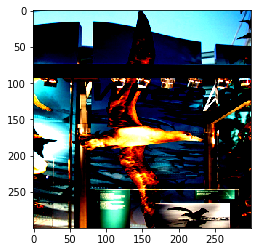

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


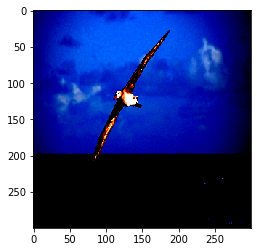

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


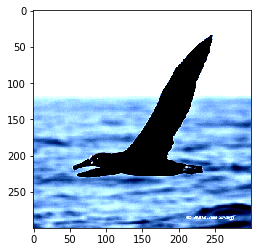

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


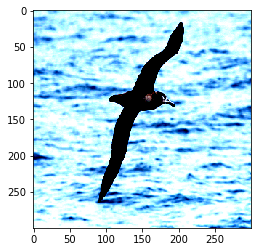

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


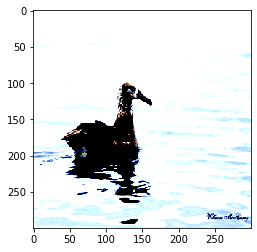

In [0]:
visualize_data(caltech_train_dataset)

In [0]:
caltech_train_dataset.class_to_idx

### Training/Testing

In [0]:
def train_model(train_loader, model, optimizer, criterion, num_epochs):
  batch_size = len(train_loader)
  step = 0

  # Training loop
  for epoch in range(0,num_epochs):
    correct = 0
    total = 0
    total_loss = 0
    for i, (img, labels) in enumerate(train_loader):
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      # img = img.view(-1, 300*300*3)
      output = model(img)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      # Calculate accuracy and total loss
      _,pred = torch.max(output,1)
      correct += (torch.sum(pred == labels)).item()
      total += len(labels)
      total_loss += loss.item()

      # Tensorboard logging
      # if ((step % 10) == 0):
      #   writer.add_scalar("Loss/train", total_loss/total, step)
      #   writer.add_scalar("Acc/train", correct/total, step)
      step = step+1
      print("--- Step: %s Acc: %s (percent) Loss: %s" %(step, 100. * correct/total, total_loss/total))
    
    print("*******************************************************************")
    print("Epoch: %s Acc: %s (percent) Loss: %s"%(epoch, 100. * correct/total, total_loss/total))
    print("*******************************************************************")

In [0]:
def test_model(test_dataloader, net):
  # TODO: Insert your code here
  accuracy_list = []

  net.eval()
  criterion = nn.NLLLoss(reduction='sum')
  total_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_dataloader:
          # send to device
          data, target = data.to(device), target.to(device)
          # permute pixels
          # data = data.view(-1, 300*300*3)
          output = net(data)
          total_loss += criterion(output, target).item() # sum up batch loss                                                               
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
          correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
          # print("Correct: " + str(correct))
  
  total_loss = total_loss / len(test_dataloader.dataset)
  accuracy = 100. * correct / len(test_dataloader.dataset)
  # logger.add_scalar("Model Testing Loss", total_loss, epoch)
  # logger.add_scalar("Model Testing Accuracy", accuracy, epoch)
  print("Test Accuracy: " + str(accuracy) + "%, Test Loss: " + str(total_loss))

### Logistic Regression
**Logistic Regression Classification**

**Q1b (2 pts):** Use PyTorch to create a Logistic Regression model to classify the Bird Datset. Plot the training curve and report the training / val accuracy in the writeup. Discuss how you tuned your hyperparameters in the writeup.

In [0]:
# TODO: INSERT CODE HERE
input_dim = 300 * 300 * 3
output_dim = 195

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 300*300*3)
        outputs = self.linear(x)
        return outputs

In [0]:
lr_model = LogisticRegression().to(device)
lr_criterion = nn.CrossEntropyLoss() 
lr_optimizer = optim.Adam(lr_model.parameters(), lr = 0.003)

lr_num_epochs = 3

# from torch.utils.tensorboard import SummaryWriter
# log = "runs/own_model"
# writer = SummaryWriter(log_dir=log)

In [0]:
train_model(caltech_train_loader, lr_model, lr_optimizer, lr_criterion, lr_num_epochs)

--- Step: 1 Acc: 0.0 (percent) Loss: 0.08389301598072052
--- Step: 2 Acc: 0.0 (percent) Loss: 3.2764037624001503
--- Step: 3 Acc: 0.5208333333333334 (percent) Loss: 5.560497507452965
--- Step: 4 Acc: 0.390625 (percent) Loss: 7.014648128300905
--- Step: 5 Acc: 0.3125 (percent) Loss: 9.080279675126075
--- Step: 6 Acc: 0.2604166666666667 (percent) Loss: 9.85922363648812
--- Step: 7 Acc: 0.22321428571428573 (percent) Loss: 10.811649554542132
--- Step: 8 Acc: 0.390625 (percent) Loss: 11.4314128998667
--- Step: 9 Acc: 0.5208333333333334 (percent) Loss: 11.7747024645408
--- Step: 10 Acc: 0.46875 (percent) Loss: 12.226972742378711
--- Step: 11 Acc: 0.42613636363636365 (percent) Loss: 12.40794829482382
--- Step: 12 Acc: 0.390625 (percent) Loss: 12.587709721177816
--- Step: 13 Acc: 0.4807692307692308 (percent) Loss: 12.898802221967625
--- Step: 14 Acc: 0.6696428571428571 (percent) Loss: 12.989315557692732
--- Step: 15 Acc: 0.625 (percent) Loss: 13.226140957077344
--- Step: 16 Acc: 0.68359375 (pe

In [0]:
test_model(caltech_val_loader, lr_model)

Test Accuracy: 2.2696929238985315%, Test Loss: -130.56430074083153


### Feed Forward
**Feed Forward Neural Network Classification**

**Q1c (3 pts):** Create a Feed Forward neural network to classify the Bird Dataset. Plot the training curve and report the training / val accuracy in the writeup. Discuss how you tuned your hyperparameters in the writeup.

In [0]:
# TODO: INSERT CODE HERE
# TODO: INSERT CODE HERE
input_dim = 300 * 300 * 3
output_dim = 195
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128,64)
        self.layer4 = nn.Linear(64,output_dim)
    def forward(self,x):
        x = x.view(-1, 300*300*3)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        # x = torch.sigmoid(x) found out this is for two class
        x = F.log_softmax(x, dim=1) # for multi class
        return x
    

In [0]:
ff_model = FeedForward().to(device)
ff_criterion = nn.CrossEntropyLoss() 
ff_optimizer = optim.Adam(ff_model.parameters(), lr = 0.003)

ff_num_epochs = 3

# from torch.utils.tensorboard import SummaryWriter
# log = "runs/own_model"
# writer = SummaryWriter(log_dir=log)

In [0]:
train_model(caltech_train_loader, ff_model, ff_optimizer, ff_criterion, ff_num_epochs)

--- Step: 1 Acc: 0.0 (percent) Loss: 0.08238685131072998
--- Step: 2 Acc: 0.78125 (percent) Loss: 0.5391059517860413
--- Step: 3 Acc: 0.5208333333333334 (percent) Loss: 0.6067858735720316
--- Step: 4 Acc: 0.390625 (percent) Loss: 0.6016882658004761
--- Step: 5 Acc: 0.625 (percent) Loss: 0.5783982634544372
--- Step: 6 Acc: 0.5208333333333334 (percent) Loss: 0.5596569031476974
--- Step: 7 Acc: 0.44642857142857145 (percent) Loss: 0.532771361725671
--- Step: 8 Acc: 0.390625 (percent) Loss: 0.4969231188297272
--- Step: 9 Acc: 0.3472222222222222 (percent) Loss: 0.4610016644001007
--- Step: 10 Acc: 0.46875 (percent) Loss: 0.4250012718141079
--- Step: 11 Acc: 0.5681818181818182 (percent) Loss: 0.39518806406042795
--- Step: 12 Acc: 0.6510416666666666 (percent) Loss: 0.3694899653395017
--- Step: 13 Acc: 0.6009615384615384 (percent) Loss: 0.34766237896222335
--- Step: 14 Acc: 0.5580357142857143 (percent) Loss: 0.3289621153048107
--- Step: 15 Acc: 0.5208333333333334 (percent) Loss: 0.3127297441164

In [0]:
test_model(caltech_val_loader, ff_model)

Test Accuracy: 0.4672897196261682%, Test Loss: 5.275230886461897


### CNN
**CNN Classification**

**Q1d (6 pts):** Create a CNN to classify the Bird Dataset. Plot the training curve and report the training / val accuracy in the writeup. Discuss how you tuned your hyperparameters in the writeup.

In [0]:
# TODO: INSERT CODE HERE

class MyCNN(nn.Module):
  def __init__(self, num_classes): 
    super(MyCNN, self).__init__() 
    self.features = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 5, stride = 2, padding = 2),
                                  nn.ReLU(inplace = True),
                                  nn.MaxPool2d(kernel_size = 3, stride = 2),
                                  nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 2),
                                  nn.ReLU(inplace = True),
                                  nn.MaxPool2d(kernel_size = 3, stride = 2),
                                  nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 2),
                                  nn.ReLU(inplace = True),
                                  nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.classifier = nn.Sequential(nn.Linear(5184, 1024),
                                    nn.ReLU(inplace = True),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(inplace = True),
                                    nn.Linear(512, 256),
                                    nn.Linear(256, 128),
                                    nn.ReLU(inplace = True),
                                    nn.Linear(128, num_classes))
  
  def forward(self, x): 
    x = self.features(x)
    x = x.view(x.size(0),-1)
    out = self.classifier(x)
    return out 

In [0]:
learning_rate = 0.003
num_classes = 195 

cnn_model = MyCNN(num_classes).to(device)
cnn_criterion = nn.CrossEntropyLoss() 
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr = learning_rate)

cnn_num_epochs = 3

# from torch.utils.tensorboard import SummaryWriter
# log = "runs/own_model"
# writer = SummaryWriter(log_dir=log)

In [0]:
train_model(caltech_train_loader, cnn_model, cnn_optimizer, cnn_criterion, cnn_num_epochs)

--- Step: 1 Acc: 1.5625 (percent) Loss: 0.0825028270483017
--- Step: 2 Acc: 0.78125 (percent) Loss: 0.08463436365127563
--- Step: 3 Acc: 0.5208333333333334 (percent) Loss: 0.08393210669358571
--- Step: 4 Acc: 0.390625 (percent) Loss: 0.08360383100807667
--- Step: 5 Acc: 0.3125 (percent) Loss: 0.08333806842565536
--- Step: 6 Acc: 0.2604166666666667 (percent) Loss: 0.08317277953028679
--- Step: 7 Acc: 0.22321428571428573 (percent) Loss: 0.08306058709110532
--- Step: 8 Acc: 0.1953125 (percent) Loss: 0.08311545383185148
--- Step: 9 Acc: 0.5208333333333334 (percent) Loss: 0.08303783999549018
--- Step: 10 Acc: 0.46875 (percent) Loss: 0.08297499790787696
--- Step: 11 Acc: 0.42613636363636365 (percent) Loss: 0.08291421356526288
--- Step: 12 Acc: 0.5208333333333334 (percent) Loss: 0.08286350034177303
--- Step: 13 Acc: 0.6009615384615384 (percent) Loss: 0.08283781202939841
--- Step: 14 Acc: 0.6696428571428571 (percent) Loss: 0.08281514580760684
--- Step: 15 Acc: 0.625 (percent) Loss: 0.082798368

In [0]:
test_model(caltech_val_loader, cnn_model)

Test Accuracy: 0.4672897196261682%, Test Loss: 0.4596070702149171


### Comparing Results
**Comparing Results**

**Q1e(2 pts):** Which model performed the best? Compare the results of your different models in your writeup.

**Submitting your solutions**
Like the previous homework assignments, complete the following headers that return a Numpy array with predictions (i.e. a 0-195 label for which class each sample belongs to). Read the **Inputs:** and **Outputs:** sections carefully.

In [0]:
# TODO: INSERT CODE HERE

input_size = 300

# resize the images in the dataset to the desired size and normalize
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

def load_test(path):
  test_data = datasets.ImageFolder(root=path, transform=input_transforms)
  return test_data



In [0]:
from PIL import Image
import torchvision.transforms.functional as TF
import glob

In [0]:
image_list = []
for filename in glob.glob('/content/caltech_test/*.jpg'): #assuming gif
    image=Image.open(filename)
    image = TF.to_tensor(image)
    image_list.append(image)
    print(image.shape)

torch.Size([3, 375, 500])
torch.Size([3, 400, 500])
torch.Size([3, 500, 375])
torch.Size([3, 350, 500])
torch.Size([3, 333, 500])
torch.Size([3, 500, 371])
torch.Size([3, 334, 500])
torch.Size([3, 333, 500])
torch.Size([3, 500, 333])
torch.Size([3, 333, 500])
torch.Size([3, 333, 500])
torch.Size([3, 333, 500])
torch.Size([3, 465, 500])
torch.Size([3, 375, 500])
torch.Size([3, 371, 500])
torch.Size([3, 357, 500])
torch.Size([3, 333, 500])
torch.Size([3, 375, 500])
torch.Size([3, 259, 500])
torch.Size([3, 500, 500])
torch.Size([3, 340, 500])
torch.Size([3, 333, 500])
torch.Size([3, 375, 500])
torch.Size([3, 364, 500])
torch.Size([3, 319, 500])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 407, 500])
torch.Size([3, 375, 500])
torch.Size([3, 448, 325])
torch.Size([3, 324, 291])
torch.Size([3, 325, 500])
torch.Size([3, 334, 500])
torch.Size([3, 500, 392])
torch.Size([3, 375, 500])
torch.Size([3, 500, 400])
torch.Size([3, 375, 500])
torch.Size([3, 400, 500])
torch.Size([

In [0]:
image_list[:5]

In [0]:
#   test_data = datasets.ImageFolder(root="/content/caltech_test", transform=input_transforms)
image = Image.open("/content/caltech_test/0000.jpg")
x = TF.to_tensor(image)
x.unsqueeze_(0)
print(x.shape)

torch.Size([1, 3, 259, 500])


In [0]:
# Inputs: The input to this function is the absolute path to the root folder of a directory of image
# from the caltech birds dataset.

# Output: Return a **numpy** array with a label from 0-195 for each of the individual images.
# Please remember to not shuffle your images so you can generate the correct predictions. The
# class label (0-195) comes from the folder name in your training dataset. For instance, any image
# from the folder named "007.Parakeet_Auklet" has a ground truth class label of "7". Your output
# should look something like: [0, 73, 165, 190, 12, ... , 93]

# Note that you have to implement three of these, one for each of the three different classifiers.

def generate_pytorch_caltech_birds_outputs(input):
  # TODO: Write your code here

  input = load_test(input)
  input = torch.FloatTensor(input).cuda()
  input = input.view(-1, 28*28)
  output = lr_model(input)
  pred = output.data.max(1, keepdim=True)[1]
  pred = pred.detach().cpu().numpy()
  print(pred)
  return pred

def generate_feedforward_caltech_birds_outputs(input):
  # TODO: Write your code here
  return None

def generate_CNN_caltech_birds_outputs(input):
  # TODO: Write your code here
  return None



In [0]:
test_case_1b = generate_caltech_ucsd_birds_predictions(generate_pytorch_caltech_birds_outputs)
test_case_1c = generate_caltech_ucsd_birds_predictions(generate_feedforward_caltech_birds_outputs)
test_case_1d = generate_caltech_ucsd_birds_predictions(generate_CNN_caltech_birds_outputs)

## Question 2. Transfer Learning on ResNets for Image Classification (15 pts)

In this question we will explore different ways to bootstrap your image classifier when training examples are scarce. For the bird dataset, we have around 15 training images for each class, and variation between each class is limited (all birds). Due to the limited number of training examples, building a high-performing image classifier is challenging. 

ImageNet is one of the most popular computer vision data sets. It  contains 10 million images in total from multiple different categories. PyTorch provides ResNets that are pre-trained on ImageNet, and using this pretrained model, we can build a bird classifier much more easily. 

**Q2 (15 pts):** In the code snippet below, load a pre-trained ResNet model and swap out the last fully connected layer from the network with your own classification layer. Train the network, plot your training accuracy, and report your final validation accuracy. 
 A few tips:

* After the last fully connected layer of the network, remember to freeze the network except for the last layer to speed up the training.

* Pretrained ResNet models assumes that input is normalized in the following fashion, and is of the size at least 224.

In [0]:
input_size_q2 = 224
input_transforms_q2 = transforms.Compose([
            transforms.Resize((input_size_q2, input_size_q2)),
            transforms.RandomRotation(40, resample=False, expand=False, center=None, fill=0),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.RandomResizedCrop(224),
            transforms.ColorJitter(brightness=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [0]:
q2_train_dataset = datasets.ImageFolder(root=caltech_dataset_train_path, transform=input_transforms_q2)
q2_train_loader = torch.utils.data.DataLoader(q2_train_dataset, batch_size=64, shuffle=True)

q2_val_dataset = datasets.ImageFolder(root=caltech_dataset_val_path, transform=input_transforms_q2)
q2_val_loader = torch.utils.data.DataLoader(q2_val_dataset, batch_size=64, shuffle=True)

# q2_train_dataset = datasets.ImageFolder(root=caltech_dataset_train_path, transform=input_transforms_q2)
# q2_train_loader = torch.utils.data.DataLoader(caltech_train_dataset, batch_size=64, shuffle=True)

# q2_val_dataset = datasets.ImageFolder(root=caltech_dataset_val_path, transform=input_transforms_q2)
# q2_val_loader = torch.utils.data.DataLoader(caltech_val_dataset, batch_size=64, shuffle=True)


In [0]:

visualize_data(q2_train_dataset, 5)

In [0]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [0]:
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(512, 195)
# resnet18.fc = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(512, 195)
# )

In [0]:
resnet_optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.002)
cross_entropy_loss= nn.CrossEntropyLoss()


In [0]:
resnet18.cuda()

train_model(q2_train_loader, resnet18, resnet_optimizer, cross_entropy_loss, 30)

In [0]:
test_model(q2_val_loader, resnet18)

In [0]:
# Inputs: The input to this function is the absolute path to the root folder of a directory of image
# from the caltech birds dataset.

# Output: Return a **numpy** array with a label from 0-195 for each of the individual images.
# Please remember to not shuffle your images so you can generate the correct predictions. The
# class label (0-195) comes from the folder name in your training dataset. For instance, any image
# from the folder named "007.Parakeet_Auklet" has a ground truth class label of "7". Your output
# should look something like: [0, 73, 165, 190, 12, ... , 93]

def generate_CNN_transfer_learning_caltech_birds_outputs(input):
  # TODO: Write your code here
  return None

In [0]:
test_case_2a = generate_caltech_ucsd_birds_predictions(generate_CNN_transfer_learning_caltech_birds_outputs)

## Question 3. Generative Models: Convolutional Autoencoders and Variational Autoencoders (30 pts)

**Note: From here onwards you will be using the UT Zappos50k dataset**

In this question you will create a Convolutional AutoEncoder (CAE) and a Variational AutoEncoder (VAE) for the UT Zappos50K Dataset. Before you *slide* into this part, please read the slides thoroughly to ensure that you understand how an autoencoder works (i.e. the loss function and general structure). 

To get good reconstruction results, the AE might take a long time to train (for instance > 2 hours); however, you should be able to tell whether or not your network is learning much earlier than that. Be sure to not just look at your loss, but also periodically examine your image outputs to ensure that they are becoming sharper and sharper representations of your input image. The choice of when to stop your AE's training is up to your discretion (however the output should be reasonably close). 





**Q3a (2 pts):** Create a PyTorch Dataset / DataLoader using the UTZappos50K dataset and visualize 5 images. Similarly, create a train/val/test split along with corresponding datasets / dataloaders. Visualize 5 images from each of these sets in your writeup. Note in your writeup what split you decided to use and your rationale why.

In [0]:
# TODO: INSERT CODE HERE
utzappos50k_dataset_path = "/content/DATASETS/UTZappos50K"


# TODO: INSERT CODE HERE
input_size = 300

# resize the images in the dataset to the desired size and normalize
input_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

utzappos_dataset = datasets.ImageFolder(root=utzappos50k_dataset_path, transform=input_transforms)

validation_split = 0.2
test_split = 0.1
train_split = 0.7
batch_size = 64
random_seed= 42

# train/val/test split
dataset_size = len(utzappos_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
print(len(train_sampler.indices))
print(len(valid_sampler.indices))

# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

utzappos_train_loader = torch.utils.data.DataLoader(utzappos_dataset, batch_size=batch_size, sampler=train_sampler)

# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

utzappos_val_loader = torch.utils.data.DataLoader(utzappos_dataset, batch_size=batch_size, sampler=valid_sampler)

print(len(utzappos_train_loader.dataset))
print(len(utzappos_val_loader.dataset))

# X_cross_val, X_test, y_cross_val, y_test = train_test_split(fashion_mnist_train_data, fashion_mnist_train_labels, test_size=0.1)
# X_train, X_val, y_train, y_val = train_test_split(X_cross_val, y_cross_val, test_size=0.22)

# utzappos_train_loader = torch.utils.data.DataLoader(utzappos_train_dataset, batch_size=64, shuffle=True)

# caltech_val_dataset = datasets.ImageFolder(root=caltech_dataset_val_path, transform=input_transforms)
# caltech_val_loader = torch.utils.data.DataLoader(caltech_val_dataset, batch_size=64, shuffle=True)

# visualize_data(utzappos_train_dataset)

# utzappos_train_dataset.class_to_idx

### CAE

**Q3b (10 pts):** Create a Convolutional AutoEncoder (CAE) to reconstruct your input images. After creating your CAE, plot the resulting training loss curve (average training loss per epoch) and in your report give 5 examples of the input and corresponding reconstruction. Also plot a validation loss curve (average validation loss per epoch).

In [0]:
# TODO: INSERT CODE HERE
class CAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 5, stride = 2, padding = 2),
                                  nn.ReLU(inplace = True),
                                  nn.MaxPool2d(kernel_size = 3, stride = 2),
                                  nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 2),
                                  nn.ReLU(inplace = True),
                                  nn.MaxPool2d(kernel_size = 3, stride = 2),
                                  nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 2),
                                  nn.ReLU(inplace = True),
                                  nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.decoder = nn.Sequential(             
        nn.ConvTranspose2d(16,6,kernel_size=5),
        nn.ReLU(True),
        nn.ConvTranspose2d(6,3,kernel_size=5),
        nn.ReLU(True))

  def forward(self, x):
    latent_vec = self.encoder(x)
    output = self.decoder(latent_vec)
    return output, latent_vec

  # def encode(self, images):

  # def decode(self, code):


In [0]:
learning_rate = 0.003

cae_model = CAE().to(device)
cae_criterion = nn.MSELoss() 
cae_optimizer = optim.Adam(cae_model.parameters(), lr = learning_rate)

cae_num_epochs = 3

# from torch.utils.tensorboard import SummaryWriter
# log = "runs/own_model"
# writer = SummaryWriter(log_dir=log)

In [0]:
train_model(utzappos_train_loader, cae_model, cae_optimizer, cae_criterion, cae_num_epochs)

### VAE
**Q3c (15 pts):** Variational AutoEncoders, as covered in class, learn the probability distribution of the inputs and can be used to generate novel images.  We can further pass convolutional features into a VAE to create a convolutional VAE.  Convert your CAE from the previous question to a convolutional VAE by executing the following steps:

* In the encoder, generate two tensors of the same length, representing mean and standard deviation of the latent probability distribution. 

* Sample from a normal distribution from the learned mean and std to generate the final encoding tensor -- this is the reparametrization trick discussed in lecture.

* Decode from the encoding tensor just as in the convolutional autoencoder. 

* Change your loss function from MSE reconstruction loss to the objective function for VAE:
 * Reconstrucation Loss: binary_cross_entropy loss between original and reconstructed image. 
 * Regularization on the sampled latent normal distribution 

$$ L_{reconstruciton} = -\frac{1}{n} \sum_{i}^{n}(x_i log(f(z_i)) + (1-x_i) log(1-f(z_i))) $$
$$ L_{regularization} = \frac{1}{2n}\sum_{i}^{n}(\mu_{i}^{2} + \sigma_{i}^2 - log(\sigma_i^2)- 1)$$
$$ L_{loss} =L_{regularization} +  L_{reconstruction}$$

In your report, plot the resulting training loss curve (average training loss per epoch) and your validation loss curve (average validation loss per epoch). In your report give 5 examples of the input and corresponding reconstruction.





In [0]:
# TODO: INSERT CODE HERE


class VAE(nn.Module):
    def __init__(self):
    def encode(self, x):
    def decode(self, z):
    def forward(self, x):


**Q3d (3 pts):** One of the many useful qualities of a VAE is that the resulting code vector has interpretable properties. To demonstrate this, choose two images from your dataset, call these images $X$ and $Y$. Compute their corresponding code vectors, call these $Z_x$ and $Z_y$ respectively. If done properly, these code vectors, when interpolated, will show an interpolation of the actual input images themselves! To linearly interpolate between $Z_x$ and $Z_y$ with interpolation factor $t$, you can use the following formula:

$$Z_{lerp} = t Z_x + (1 - t) Z_y$$

Calculate $Z_{lerp}$ with interpolation factors: $t \in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]$. For each of these interpolation factors, display the corresponding reconstruction in your writeup. Explain your results.

**Extra Credit (5 pts):** For extra credit, try linear interpolation factors with a smaller interval than 0.1 (like 0.01 for instance) and create a video from the intermediate results, showing how by interpolating between code vectors, you can smoothly get from a reconstruction of $X$ to a reconstruction of $Y$!

In [0]:
# TODO: INSERT CODE HERE

## Question 4. Generative Models: Generative Adversarial Networks (GAN's) (40 pts)

In this question you will create a Generative Adversarial Network (GAN) for the UT Zappos50K. Before you embark on this part, please read the slides thoroughly to ensure that you understand how the multiple loss functions and general structure of a GAN works. 

GANs are notoriously difficult to train, with each attempt taking a decent amount of time to run. Please start early, as underestimating how much time it takes to train a GAN led many students to not finish on time last year.



#### Tuning Values

In [0]:
global_batch_size = 86 #can the batch size of the z vector and the real image loader be different
gan_feature_length = 84 ##

discriminator_lr = 6e-4 #5e-5?

generator_lr = 9e-4 ### Change the discriminator rate. 

num_zeros_added_discriminator_loss = 5

gan_num_training_epochs = 25 #10?

##Discriminator Loss Fnc
zero_label_prob_tuple = (0, 7)
zero_label_noise_level = 0.15
one_label_prob_tuple = (0, 11)
one_label_noise_level = 0.85

flip_prob_tuple = (0,25)

tensorboard_graph_name = "monday_shoes_3"

def init_kaiming_norm(m):
    if (type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d) :
        nn.init.kaiming_normal_(m.weight, mode='fan_in')

#### Tensorboard 

In [8]:
ROOT_LOG_DIR = "/content/drive/My Drive/Colab Notebooks/CIS522/HW3/TensorBoard"
import os
# from torch.utils.tensorboard import SummaryWriter
# TENSORBOARD_DIR = "Problem1_Final" # Sub-Directory for storing this specific experiment's logs
# logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, TENSORBOARD_DIR))

%load_ext tensorboard
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

**Q4a (0 pts):** Create a normally distributed vector $z$ with $\mu = 0$, 

1.   List item
2.   List item

$\sigma = 1$ (i.e the np.random.normal default). The vector should have size [batch size, feature length, 1, 1]. You don't need to submit anything for this part. Here feature length describes the length of your vector $z$.


In [9]:
# import numpy as np
# import torch
def create_z_vector(batch_size= 64, feature_length= 100):
  z= np.random.normal(0, 1, (batch_size, feature_length))
  z= z.reshape((batch_size, feature_length, 1, 1))
  z= torch.tensor(z).float().to(device)
  return z


# device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
z= create_z_vector().to(device)
print(z.shape)

torch.Size([64, 100, 1, 1])


**Q4b (5 pts):** Create the generator network. Use [ConvTranspose2d](https://pytorch.org/docs/stable/nn.html) to upsample the noise vector $z$ to a size of your choosing (512 is what we used but you can/should tune this). Deconvolve it until the number of channels is 3 (so it's RGB), and the output size is (64,64).  In other words, the output of the generator should be [batch size,3,64,64]. Use ReLU and batch norm after every deconvolution and use a sigmoid layer at the end to create your final output. Don't worry about the loss function for now. Describe what your final network looks like in your writeup and why you made these choices.

#### Generator

In [0]:
#Generator class
import pdb

class Q3Generator(nn.Module):
  def __init__(self, in_size, out_size):
      super(Q3Generator, self).__init__()
    #   pdb.set_trace()
      self.main = nn.Sequential(
          nn.ConvTranspose2d(in_channels=in_size, out_channels= 160, kernel_size=8, stride=1, padding=0, output_padding=0, dilation=1, bias=False),
          nn.BatchNorm2d(160),
          nn.ReLU(True),
          nn.ConvTranspose2d(in_channels=160, out_channels=160, kernel_size=6, stride=1, padding=0, output_padding=0 , dilation=1, bias=False),
          nn.BatchNorm2d(160),
          nn.ReLU(True),
          nn.ConvTranspose2d(in_channels=160, out_channels= 128, kernel_size=4, stride=1, padding=0, output_padding=0, dilation=1, bias=False),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
          nn.ConvTranspose2d(in_channels=128, out_channels= 40, kernel_size=2, stride=2, padding=0, output_padding=0, dilation=1, bias=False),
          nn.BatchNorm2d(40),
          nn.ReLU(True),
          nn.ConvTranspose2d(in_channels=40, out_channels= 3, kernel_size=2, stride=2, padding=0, output_padding=0, dilation=1, bias=False),
          nn.Tanh()
          )

  def forward(self, x):
      return self.main(x)



**Q4c (5 pts):** Create the discriminator network. This should feel very similar to creating a CNN to classify whether an example is in the distribution or not in the distribution. Don't worry about the loss function for this part. Describe what your final network looks like in your writeup and why you made these choices.

#### Discriminator

In [0]:
class Q3Discriminator(nn.Module):
    def __init__(self):
        super(Q3Discriminator, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=128, kernel_size=5, stride=2, padding=2, dilation=1, bias=False),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                      nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3, stride=2, padding=2, dilation=1, bias=False),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(True),
                                      nn.MaxPool2d(kernel_size = 3, stride = 2),
                                      )
        self.classifier = nn.Sequential(nn.Dropout(p=0.4, inplace=True),
                                        nn.Linear(2048, 1),
                                        nn.Sigmoid())
        
    def forward(self, x):

        out = self.features(x)
        out = out.view(out.size(0), -1)


        out = self.classifier(out)

        return out

**Q4d (4 pts):** Code the loss function for the generator, it should be as follows:

$$ L_G = -\frac{1}{n}\sum_{i=1}^{n}\lg D(G(z))$$

An alternate form for convenince is:
$$ L_G = \frac{1}{n}\sum_{i=1}^{n}L_{CE}(D(G(z)), 1)$$

Where $L_{CE}$ is the cross entropy loss function and n is the batch size. Why is the ground truth label for fake data 1 here? Explain your answer in the write-up.





#### generator_loss

In [0]:

#generator loss
def generator_loss(discriminator_fn, generator_fn, z_vec):

    

    bce = nn.BCELoss(reduction='mean')
    generator_out = generator_fn(z_vec)
    

    discriminator_out = discriminator_fn(generator_out)
    actual_labels = torch.ones_like(discriminator_out)

    bce_out = bce(discriminator_out, actual_labels.cuda())
    return bce_out
    


In [23]:


### Unit testing

d_net = Q3Discriminator()
g_net = Q3Generator(100,3)

generator_loss(d_net.cuda(), g_net.cuda(), z.cuda())

# d_optimizer = optim.Adam(d_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# g_optimizer = optim.Adam(g_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

tensor(0.4526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

**Q4e (4 pts):** Code the loss function for the discriminator, it should be as follows:

$$ L_D = \frac{1}{2n}\sum_{i=1}^{n}L_{CE}(D(X_i), 1) + L_{CE}(D(G(z)), 0)$$

Where $L_{CE}$ is the cross entropy loss function and n is the batch size. Be sure that you're not normalizing by $n$ twice (if you feed in two vectors into BCELoss, they normalize it by the size of the vector for you).

**Important:** Remember to **detach** your generator when calculating this loss. Think about why this is the case and the repercussions of not doing so. Detail the answer to this question in your write-up.

#### discriminator_loss

In [0]:
# TODO: INSERT CODE HERE


def add_zeros_to_tensor(one_tensor, num_of_zeros):

    for i in range(num_of_zeros):
        chosen = random.randint(0,len(one_tensor) - 1)

        one_tensor[chosen] = 0

    return one_tensor

def maybe_noisy_tensors(input_tensor, noise_level, prob_to_noise, prob_to_flip):
    should_noise = random.randint(prob_to_noise[0], prob_to_noise[1])
    should_flip_labels = random.randint(prob_to_flip[0], prob_to_flip[1])
    new_shape = input_tensor.shape
    if (should_noise == 0):
        

        input_tensor = input_tensor.new_full(size=new_shape, fill_value=noise_level)
    elif(should_flip_labels == 0):
        if (input_tensor[0] == 0):
            input_tensor = input_tensor.new_full(size=new_shape, fill_value=1)
        else:
            input_tensor = input_tensor.new_full(size=new_shape, fill_value=0)


        

    return input_tensor




def discriminator_loss(discriminator_fn, generator_fn, z_vec, imgs):
    


    bce = nn.BCELoss(reduction='mean')
    fake_gen_out = generator_fn(z_vec)
    fake_discriminator_out = discriminator_fn(fake_gen_out.detach())


    zero_labels = torch.zeros_like(fake_discriminator_out)



    zero_labels = maybe_noisy_tensors(input_tensor=zero_labels,
                                              noise_level=zero_label_noise_level,
                                              prob_to_noise=zero_label_prob_tuple, prob_to_flip=flip_prob_tuple)
    

    fake_loss = bce(fake_discriminator_out, zero_labels.cuda())


    

    real_discriminator_out = discriminator_fn(imgs.detach())
    
    one_labels = torch.ones_like(real_discriminator_out)



    one_labels = maybe_noisy_tensors(input_tensor=one_labels,
                                     noise_level=one_label_noise_level,
                                     prob_to_noise=one_label_prob_tuple, prob_to_flip=flip_prob_tuple)




    one_labels = add_zeros_to_tensor(one_labels, num_zeros_added_discriminator_loss)



    real_loss = bce(real_discriminator_out, one_labels.cuda())
    total_loss = real_loss + fake_loss
    

    return total_loss, real_loss, fake_loss

In [25]:

d_net = Q3Discriminator().cuda()
g_net = Q3Generator(100,3).cuda()
z = z.cuda()
discriminator_loss(d_net, g_net, z, g_net(z))


# print(g_net(z).cpu().detach())

(tensor(1.5197, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.6341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.8855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))

In [26]:
maybe_noisy_tensors(input_tensor=torch.ones(100), noise_level=0.15, prob_to_noise=[0,50], prob_to_flip=flip_prob_tuple)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

**Q4f (2 pts):** Create two optimizers, one for your Discriminator network and one for your generator network. Describe your choices for the learning rate and optimizer in the writeup.

In [0]:
# # TODO: INSERT CODE HERE
# d_optimizer = optim.Adam(d_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# g_optimizer = optim.Adam(g_net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

**Q4g (20 pts):** Put all of these parts together to create a GAN. The training loop should look as follows:

**Training Loop:**

1.   Create your vector $z$
2.   Zero out the gradient for $G$
3.   Generate your fake image, and calculate $L_G$
4.   Backpropagate $L_G$ and have your optimizer take a step
5.   Zero out the gradient for $D$
6.   Calculate $L_D$
7.   Backpropagate $L_D$ and step your optimizer.

**Hints for training:**

1.   Make sure you're using tensorboard to keep track of the discriminator AND generator losses throughout. Note that if your discriminator loss goes to 0, this represents a failure mode of your training (look at how the generator loss function is calculated and you realize that G's gradients vanish).
2.   Keep vigilant for mode collapse. Display your image after every delta number of iterations to see that not only is your image getting better, but you're also not getting the same image each time. If so, then your network is suffering from mode collapse.
3.   Analyze your generator loss and make sure that it's roughly oscillating around a certain loss. Unlike most other tasks, your generator and discriminator loss are NOT intended to monotonically decrease. Instead they should bounce around a certain loss (see image below for example). Your graph doesn't have to look exactly like this but this is meant to illustrate how the loss should roughly bounce around a certain loss.
![Discriminator Loss](https://i.imgur.com/07JYtA1.png)
![Generator Loss Graph](https://i.imgur.com/NoMFLNg.png)

On the left is the discriminator loss graph, and as you can see, the discriminator loss as a whole goes down but not monotonically. It bounces around signifcantly at each iteration. On the right is the generator graph, whose loss actually increases. Like the discriminator loss graph, you can see that the loss varies significantly from iteration to iteration.


**Hyperparameter Tuning:**

What makes GAN's difficult to train is that they are extremely sensitive to hyperparameters. Some hyperparameters to think about when tuning your GAN:


1.   The number of times you run your discriminator vs. your generator (generally you run your discriminator more times than your generator because the discriminator is what gives your generator feedback).
2.   The learning rate for your discriminator / generator
3.   Your image output size
4.   Your feature vector size (i.e. the length of z)
5.   Your standard neural network hyperparameters (i.e. number of layers, width of layers, batch size, etc.)



There are many sources online that provide help with how to train a GAN -- feel free to look them up! Of course you may not copy code from online sources (please review the collaboration policy) but we encourage you to look up articles online to help debug your GAN. Here are a few examples that we particularly like:

1.   [Keep Calm and train a GAN](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9)
2.   [Why is it so hard to train GAN's!](https://medium.com/@jonathan_hui/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b)

And many more!

Be sure to start this part early as you will definitely run into issues with training that you wouldn't originally forsee!

After you finish creating your GAN, give us 5 of your best outputs (not all of your results will look reasonable) and plot your training curve for both the generator AND discriminator. Report your final hyper-parameter choices that weren't already reported above (i.e. the batch size, model parameters, etc.)



#### zappos dataloader and visualization

tensor(1.)
tensor(-0.9216)
tensor(1.)
tensor(0.0392)


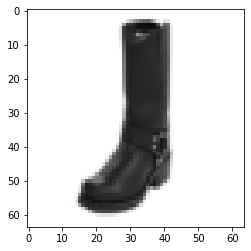

tensor(1.)
tensor(-0.8510)
tensor(1.)
tensor(0.0745)


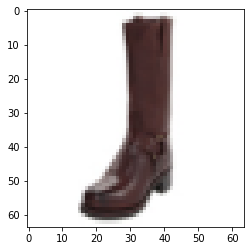

tensor(1.)
tensor(-0.8902)
tensor(1.)
tensor(0.0549)


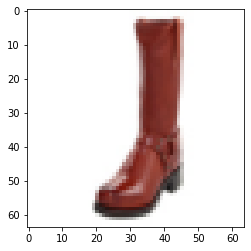

tensor(1.)
tensor(-0.8353)
tensor(1.)
tensor(0.0824)


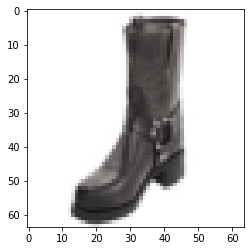

tensor(1.)
tensor(-0.9373)
tensor(1.)
tensor(0.0314)


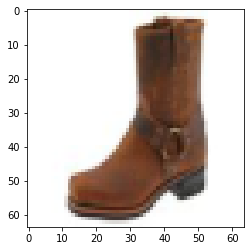

In [28]:
def vis_gan_data(data, number_of_images = 5):
  fig = plt.figure()
  for i in range(number_of_images):
    img = data[i][0]
    img = img.permute(1,2,0)
    # img = tf.transpose(img, [1, 2, 0])

    print(torch.max(img))
    print(torch.min(img))

    img = img + 1
    img = img / 2

    print(torch.max(img))
    print(torch.min(img))

    torch.set_printoptions(profile="full")
    # print(img)
    torch.set_printoptions(profile="default")

    plt.imshow(img)
    plt.show()


q4_transforms = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])


zappos50k_dataset_path = "/content/DATASETS/UTZappos50K"
zappos_gan_dataset = datasets.ImageFolder(root=zappos50k_dataset_path, transform=q4_transforms)

zappos_real_loader = torch.utils.data.DataLoader(zappos_gan_dataset, batch_size=global_batch_size, shuffle=True)


vis_gan_data(zappos_gan_dataset, 5)

In [0]:
# def generate_images(g, z, rows, cols, name= "UTZappos", show= True):
#   '''
#   Displays the images in a rows * cols grid
#   '''
#   imgs= g(z)
#   print(imgs.shape)
#   imgs= imgs[:rows*cols].cpu().detach().numpy()
#   print(imgs.shape)
#   #imgs= 0.5* imgs + 0.5
#   fig, ax= plt.subplots(rows, cols)
#   count= 0
# #   print(imgs.shape)
#   imgs = np.reshape(imgs, (imgs.shape[0], 64, 64, 3))
#   imgs = np.clip(imgs, a_min = 0, a_max = 255) 

#   for row in range(rows):
#     for col in range(cols):
#       img= imgs[count]
#       ax[row, col].imshow(img)
#       ax[row, col].axis('off')
#       count += 1
#   fig.suptitle(name)
# #   fig.savefig("%s.png"%(name))
#   if(show): 
#     plt.show()
#   else: 
#     plt.close()


def gen_images(generator, my_z, rows, columns):

    image_gen = generator(my_z).cpu().detach()
    # print(image_gen)
    # plt.imshow(image_gen[0].permute(1, 2, 0))
    count = 0
    fig, ax= plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            image = (image_gen[count].permute(1, 2, 0))
            # print(image)

            image = image + 1
            image = image / 2

            ax[r, c].imshow(image)
            ax[r, c].axis('off')
            count += 1

    plt.show()

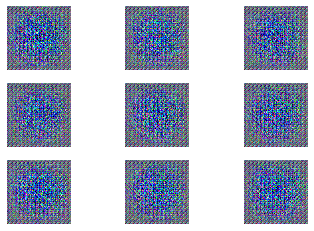

In [30]:
d_net_2 = Q3Discriminator()
g_net_2 = Q3Generator(gan_feature_length,3)

g_net_2.cuda()
z1 = create_z_vector(batch_size=global_batch_size, feature_length=gan_feature_length).to(device)
# print(z1)
# generate_images(g_net_2, z1, 4, 4, "mnist_test", True)

gen_images(g_net_2, z1, 3, 3)
# g_net.cuda()
# output = g_net(z1)

#### Initialize optimizer and networks

In [31]:
d_net = Q3Discriminator()
g_net = Q3Generator(gan_feature_length,3)

d_optimizer = optim.Adam(d_net.parameters(), lr=discriminator_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
g_optimizer = optim.Adam(g_net.parameters(), lr=generator_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


d_net.apply(init_kaiming_norm)
g_net.apply(init_kaiming_norm)

Q3Generator(
  (main): Sequential(
    (0): ConvTranspose2d(84, 160, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(160, 160, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (4): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(160, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 40, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (10): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(40, 3, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (13): Tanh()
  )
)

#### Train Def

In [32]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(os.path.join(ROOT_LOG_DIR, tensorboard_graph_name))

def gan_train(real_img_loader, g_network, d_network, g_optimizer, d_optimizer, num_epochs):
    d_network.cuda()
    g_network.cuda()
    step = 0
    
    for epoch in range(0,num_epochs):

        
        for i, (X, y) in enumerate(real_img_loader):
            
            img = X.to(device)
            step += 1
            
            z_vector = create_z_vector(batch_size= global_batch_size, feature_length= gan_feature_length)

            g_network.zero_grad()
            g_loss = generator_loss(d_network, g_network, z_vector)
            g_loss.backward()
            g_optimizer.step()
            ###
            
            d_network.zero_grad()
            d_loss, r_loss, f_loss = discriminator_loss(d_network, g_network, z_vector, img)
            d_loss.backward()
            d_optimizer.step()


            if step % 200 == 0: 
                print("[%d/%d : %d] G Loss: %.4f\t D Loss: %.4f\t D Loss(real): %.4f\t D Loss (fake):%.4f\t" %(epoch, num_epochs, step, g_loss, d_loss, r_loss, f_loss))
                writer.add_scalar("G Loss", g_loss, step)
                writer.add_scalar("D Loss/real",r_loss, step)
                writer.add_scalar("D Loss/fake", f_loss, step)
                # gen_images(g_network, z_vector, 3, 3)


            if step % 2000 == 0:
                gen_images(g_network, z_vector, 3, 3)
                # torch.save(g_network.state_dict(), "models/generator-%d.pt"%(int(time.time())))
                # torch.save(d_network.state_dict(), "models/discriminator-%d.pt"%(int(time.time())))
                # print("MODEL ID %d.pt"%(int(time.time())))








#### Train this bad boi

[0/25 : 200] G Loss: 1.5163	 D Loss: 0.6933	 D Loss(real): 0.2531	 D Loss (fake):0.4402	
[0/25 : 400] G Loss: 1.6816	 D Loss: 0.7658	 D Loss(real): 0.4249	 D Loss (fake):0.3409	
[1/25 : 600] G Loss: 1.1100	 D Loss: 1.0002	 D Loss(real): 0.2677	 D Loss (fake):0.7326	
[1/25 : 800] G Loss: 1.1898	 D Loss: 0.9241	 D Loss(real): 0.3330	 D Loss (fake):0.5911	
[1/25 : 1000] G Loss: 2.1514	 D Loss: 0.7018	 D Loss(real): 0.4906	 D Loss (fake):0.2112	
[2/25 : 1200] G Loss: 2.1809	 D Loss: 0.8583	 D Loss(real): 0.6317	 D Loss (fake):0.2266	
[2/25 : 1400] G Loss: 2.4069	 D Loss: 1.2212	 D Loss(real): 1.0828	 D Loss (fake):0.1384	
[2/25 : 1600] G Loss: 1.4998	 D Loss: 0.6962	 D Loss(real): 0.3409	 D Loss (fake):0.3554	
[3/25 : 1800] G Loss: 2.8383	 D Loss: 0.4973	 D Loss(real): 0.3739	 D Loss (fake):0.1234	
[3/25 : 2000] G Loss: 2.1542	 D Loss: 0.9273	 D Loss(real): 0.7044	 D Loss (fake):0.2230	


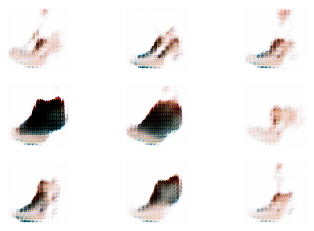

[3/25 : 2200] G Loss: 1.3102	 D Loss: 0.8064	 D Loss(real): 0.3215	 D Loss (fake):0.4849	
[4/25 : 2400] G Loss: 1.9173	 D Loss: 1.0167	 D Loss(real): 0.7287	 D Loss (fake):0.2880	
[4/25 : 2600] G Loss: 1.4627	 D Loss: 0.7843	 D Loss(real): 0.4011	 D Loss (fake):0.3832	
[4/25 : 2800] G Loss: 1.5341	 D Loss: 0.8666	 D Loss(real): 0.5052	 D Loss (fake):0.3615	
[5/25 : 3000] G Loss: 1.8875	 D Loss: 0.8756	 D Loss(real): 0.6254	 D Loss (fake):0.2502	
[5/25 : 3200] G Loss: 2.4214	 D Loss: 0.8913	 D Loss(real): 0.6776	 D Loss (fake):0.2137	
[5/25 : 3400] G Loss: 1.4702	 D Loss: 0.8980	 D Loss(real): 0.4603	 D Loss (fake):0.4377	
[6/25 : 3600] G Loss: 1.5581	 D Loss: 0.9559	 D Loss(real): 0.4594	 D Loss (fake):0.4965	
[6/25 : 3800] G Loss: 1.1412	 D Loss: 1.0078	 D Loss(real): 0.4633	 D Loss (fake):0.5446	
[6/25 : 4000] G Loss: 0.8703	 D Loss: 1.1063	 D Loss(real): 0.3022	 D Loss (fake):0.8040	


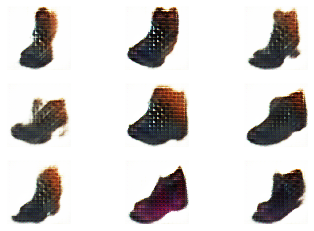

[7/25 : 4200] G Loss: 1.7828	 D Loss: 1.0038	 D Loss(real): 0.6541	 D Loss (fake):0.3496	
[7/25 : 4400] G Loss: 0.8898	 D Loss: 1.3802	 D Loss(real): 0.5949	 D Loss (fake):0.7853	
[7/25 : 4600] G Loss: 0.6931	 D Loss: 1.4170	 D Loss(real): 0.3645	 D Loss (fake):1.0525	
[8/25 : 4800] G Loss: 1.6964	 D Loss: 1.1738	 D Loss(real): 0.8912	 D Loss (fake):0.2826	
[8/25 : 5000] G Loss: 1.0292	 D Loss: 1.1187	 D Loss(real): 0.4544	 D Loss (fake):0.6643	
[8/25 : 5200] G Loss: 1.2511	 D Loss: 0.9332	 D Loss(real): 0.4455	 D Loss (fake):0.4877	
[9/25 : 5400] G Loss: 1.3866	 D Loss: 1.2429	 D Loss(real): 0.8170	 D Loss (fake):0.4259	
[9/25 : 5600] G Loss: 1.2375	 D Loss: 1.0955	 D Loss(real): 0.6272	 D Loss (fake):0.4683	
[9/25 : 5800] G Loss: 0.6849	 D Loss: 1.3064	 D Loss(real): 0.3889	 D Loss (fake):0.9174	
[10/25 : 6000] G Loss: 1.2933	 D Loss: 1.0374	 D Loss(real): 0.4918	 D Loss (fake):0.5456	


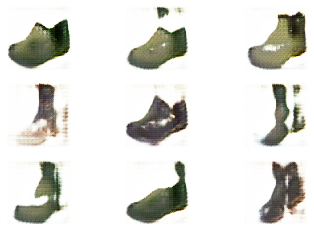

[10/25 : 6200] G Loss: 1.6647	 D Loss: 2.2767	 D Loss(real): 0.7640	 D Loss (fake):1.5127	
[10/25 : 6400] G Loss: 1.3284	 D Loss: 1.1279	 D Loss(real): 0.7061	 D Loss (fake):0.4218	
[11/25 : 6600] G Loss: 1.0352	 D Loss: 1.2978	 D Loss(real): 0.6667	 D Loss (fake):0.6311	
[11/25 : 6800] G Loss: 0.7061	 D Loss: 1.4216	 D Loss(real): 0.4949	 D Loss (fake):0.9268	
[12/25 : 7000] G Loss: 2.0831	 D Loss: 3.2225	 D Loss(real): 1.1046	 D Loss (fake):2.1178	
[12/25 : 7200] G Loss: 1.0740	 D Loss: 1.1785	 D Loss(real): 0.6426	 D Loss (fake):0.5359	
[12/25 : 7400] G Loss: 0.7243	 D Loss: 1.2340	 D Loss(real): 0.5162	 D Loss (fake):0.7178	
[13/25 : 7600] G Loss: 0.9598	 D Loss: 1.0309	 D Loss(real): 0.4891	 D Loss (fake):0.5419	
[13/25 : 7800] G Loss: 0.8618	 D Loss: 1.2494	 D Loss(real): 0.4943	 D Loss (fake):0.7551	
[13/25 : 8000] G Loss: 1.9781	 D Loss: 1.0360	 D Loss(real): 0.8319	 D Loss (fake):0.2041	


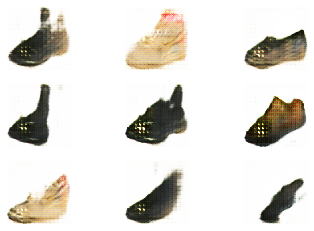

[14/25 : 8200] G Loss: 1.4471	 D Loss: 1.2581	 D Loss(real): 0.9146	 D Loss (fake):0.3435	
[14/25 : 8400] G Loss: 1.0426	 D Loss: 1.3012	 D Loss(real): 0.6891	 D Loss (fake):0.6121	
[14/25 : 8600] G Loss: 1.4732	 D Loss: 1.3292	 D Loss(real): 1.0020	 D Loss (fake):0.3272	
[15/25 : 8800] G Loss: 1.3677	 D Loss: 1.4519	 D Loss(real): 1.0446	 D Loss (fake):0.4072	
[15/25 : 9000] G Loss: 1.5619	 D Loss: 1.1632	 D Loss(real): 0.8463	 D Loss (fake):0.3169	
[15/25 : 9200] G Loss: 0.6753	 D Loss: 1.2717	 D Loss(real): 0.4194	 D Loss (fake):0.8524	
[16/25 : 9400] G Loss: 1.3002	 D Loss: 0.9231	 D Loss(real): 0.5086	 D Loss (fake):0.4145	
[16/25 : 9600] G Loss: 1.3443	 D Loss: 1.3044	 D Loss(real): 0.8899	 D Loss (fake):0.4146	
[16/25 : 9800] G Loss: 1.2292	 D Loss: 1.3209	 D Loss(real): 0.7431	 D Loss (fake):0.5778	
[17/25 : 10000] G Loss: 0.9152	 D Loss: 1.2708	 D Loss(real): 0.6883	 D Loss (fake):0.5825	


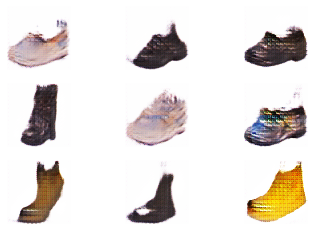

[17/25 : 10200] G Loss: 1.2059	 D Loss: 1.0921	 D Loss(real): 0.6218	 D Loss (fake):0.4703	
[17/25 : 10400] G Loss: 0.9214	 D Loss: 1.2121	 D Loss(real): 0.5581	 D Loss (fake):0.6539	
[18/25 : 10600] G Loss: 0.8411	 D Loss: 1.3426	 D Loss(real): 0.5998	 D Loss (fake):0.7427	
[18/25 : 10800] G Loss: 0.6598	 D Loss: 1.3222	 D Loss(real): 0.4204	 D Loss (fake):0.9018	
[18/25 : 11000] G Loss: 1.1496	 D Loss: 1.1477	 D Loss(real): 0.5855	 D Loss (fake):0.5622	
[19/25 : 11200] G Loss: 1.1222	 D Loss: 1.2407	 D Loss(real): 0.7034	 D Loss (fake):0.5374	
[19/25 : 11400] G Loss: 1.2196	 D Loss: 1.1420	 D Loss(real): 0.6840	 D Loss (fake):0.4581	
[19/25 : 11600] G Loss: 1.3595	 D Loss: 1.0464	 D Loss(real): 0.6317	 D Loss (fake):0.4147	
[20/25 : 11800] G Loss: 1.8760	 D Loss: 1.3004	 D Loss(real): 1.0919	 D Loss (fake):0.2085	
[20/25 : 12000] G Loss: 1.5477	 D Loss: 1.2185	 D Loss(real): 0.9155	 D Loss (fake):0.3030	


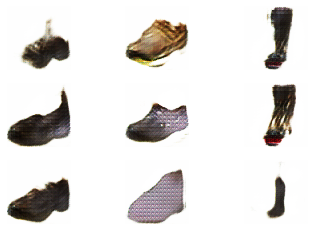

[20/25 : 12200] G Loss: 1.3879	 D Loss: 1.2284	 D Loss(real): 0.8830	 D Loss (fake):0.3454	
[21/25 : 12400] G Loss: 1.1252	 D Loss: 1.6646	 D Loss(real): 1.0665	 D Loss (fake):0.5981	
[21/25 : 12600] G Loss: 1.1940	 D Loss: 1.0961	 D Loss(real): 0.5431	 D Loss (fake):0.5530	
[21/25 : 12800] G Loss: 1.2221	 D Loss: 1.0755	 D Loss(real): 0.6550	 D Loss (fake):0.4205	
[22/25 : 13000] G Loss: 0.9785	 D Loss: 1.4169	 D Loss(real): 0.7621	 D Loss (fake):0.6548	
[22/25 : 13200] G Loss: 2.1143	 D Loss: 1.5176	 D Loss(real): 1.2998	 D Loss (fake):0.2178	
[23/25 : 13400] G Loss: 1.2668	 D Loss: 1.1115	 D Loss(real): 0.6517	 D Loss (fake):0.4597	
[23/25 : 13600] G Loss: 0.8554	 D Loss: 1.1787	 D Loss(real): 0.5049	 D Loss (fake):0.6738	
[23/25 : 13800] G Loss: 0.9508	 D Loss: 1.1812	 D Loss(real): 0.5628	 D Loss (fake):0.6184	
[24/25 : 14000] G Loss: 1.0266	 D Loss: 1.1396	 D Loss(real): 0.5946	 D Loss (fake):0.5450	


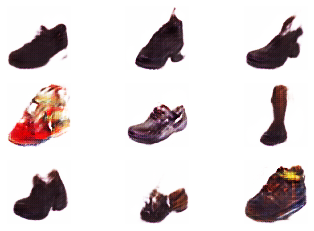

[24/25 : 14200] G Loss: 1.2165	 D Loss: 1.1998	 D Loss(real): 0.7612	 D Loss (fake):0.4386	
[24/25 : 14400] G Loss: 0.6958	 D Loss: 1.3324	 D Loss(real): 0.5747	 D Loss (fake):0.7577	


In [33]:
gan_train(zappos_real_loader, g_net, d_net, g_optimizer,  d_optimizer, gan_num_training_epochs)

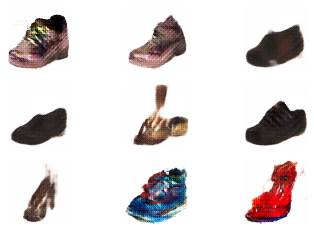

In [38]:
z11 = create_z_vector(batch_size=global_batch_size, feature_length=gan_feature_length).to(device)
# print(z1)
gen_images(g_net, z11, 3, 3)






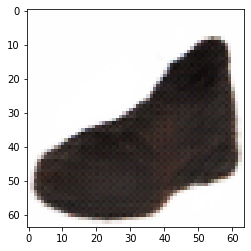

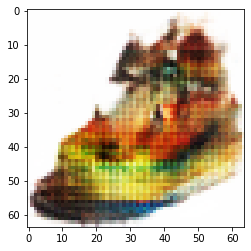

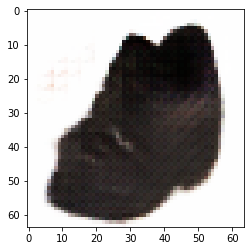

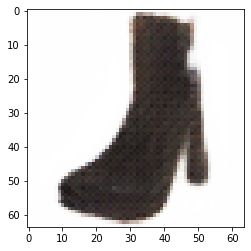

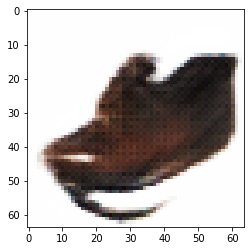

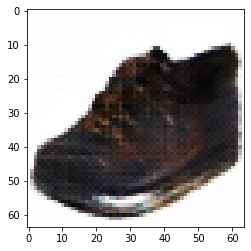

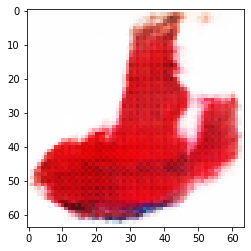

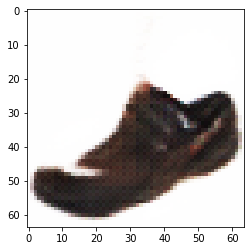

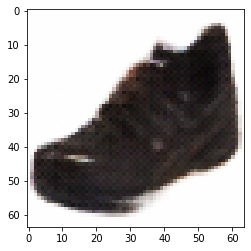

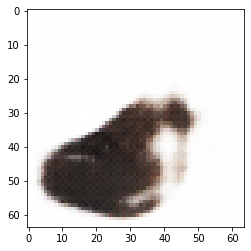

In [39]:
z11 = create_z_vector(batch_size=global_batch_size, feature_length=gan_feature_length).to(device)

my_img1 = g_net(z11)


for i in range(10):
    single_img1 = (my_img1[i].detach().cpu().permute(1, 2, 0))
    # print(im\age)

    single_img1 = single_img1 + 1
    single_img1 = single_img1 / 2

    plt.imshow(single_img1)
    plt.show()


#### Overfit architecture to one image

In [0]:
torch.save(g_net.state_dict(), "/content/drive/My Drive/Colab Notebooks/CIS522/HW3/Models/generator_relu_discriminator_relu_generator_more_top_filters")
torch.save(d_net.state_dict(), "/content/drive/My Drive/Colab Notebooks/CIS522/HW3/Models/discriminator_leaky_discriminator_relu_generator_more_top_filters")

In [0]:
def display_single(generator, my_z):

    image_gen = generator(my_z).cpu().detach()
    # print(image_gen)
    plt.imshow(image_gen[0].permute(1, 2, 0))
    # plt.imshow(image_gen)

    plt.show()

In [0]:
# d_net_overfit = Q3Discriminator()
# g_net_overfit = Q3Generator(gan_feature_length,3)

d_net = Q3Discriminator()
g_net = Q3Generator(gan_feature_length,3)


d_optimizert_overfit = optim.Adam(d_net.parameters(), lr=discriminator_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
g_optimizert_overfit = optim.Adam(g_net.parameters(), lr=generator_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

zappos_overfit = torch.utils.data.DataLoader(zappos_gan_dataset, batch_size=1, shuffle=True)


In [0]:
overfit_img = None
for i, (X, y) in enumerate(zappos_overfit):
    plt.imshow(X[0].permute(1, 2, 0))
    overfit_img = X
    break

print(overfit_img)


In [0]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(os.path.join(ROOT_LOG_DIR, "overfit-3"))

def overfit_train(real_img_loader, g_network, d_network, g_optimizer, d_optimizer, num_epochs, img):
    d_network.cuda()
    g_network.cuda()
    step = 0
    img = img.cuda()
    z_vector = create_z_vector(batch_size=1, feature_length= gan_feature_length)    

    
    print("hello")
    for epoch in range(0,num_epochs):

        step += 1
            

        g_network.zero_grad()
        g_loss = generator_loss(d_network, g_network, z_vector)
        g_loss.backward()
        g_optimizer.step()
        ###
            
        d_network.zero_grad()
        d_loss, r_loss, f_loss = discriminator_loss(d_network, g_network, z_vector, img)
        d_loss.backward()
        d_optimizer.step()


        if step % 200 == 0: 
            print("[%d/%d : %d] G Loss: %.4f\t D Loss: %.4f\t D Loss(real): %.4f\t D Loss (fake):%.4f\t" %(epoch, num_epochs, step, g_loss, d_loss, r_loss, f_loss))
            writer.add_scalar("G Loss", g_loss, step)
            writer.add_scalar("D Loss/real",r_loss, step)
            writer.add_scalar("D Loss/fake", f_loss, step)
            display_single(g_network, z_vector)


        if step % 2000 == 0:
            display_single(g_network, z_vector)
            # torch.save(g_network.state_dict(), "models/generator-%d.pt"%(int(time.time())))
            # torch.save(d_network.state_dict(), "models/discriminator-%d.pt"%(int(time.time())))
            # print("MODEL ID %d.pt"%(int(time.time())))








hello
[199/20000 : 200] G Loss: 4.0202	 D Loss: 0.0214	 D Loss(real): 0.0000	 D Loss (fake):0.0214	


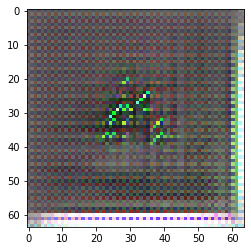

[399/20000 : 400] G Loss: 4.8208	 D Loss: 0.0173	 D Loss(real): 0.0000	 D Loss (fake):0.0173	


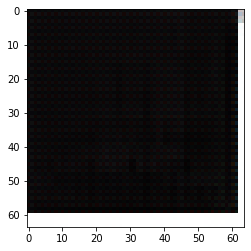

[599/20000 : 600] G Loss: 3.8615	 D Loss: 0.0159	 D Loss(real): 0.0000	 D Loss (fake):0.0159	


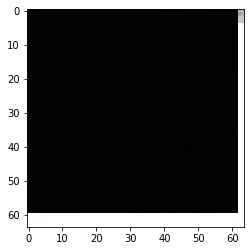

[799/20000 : 800] G Loss: 3.3815	 D Loss: 0.0334	 D Loss(real): 0.0000	 D Loss (fake):0.0334	


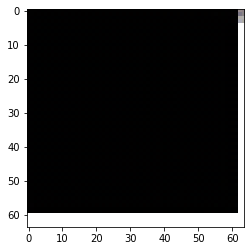

[999/20000 : 1000] G Loss: 4.4694	 D Loss: 0.0077	 D Loss(real): 0.0000	 D Loss (fake):0.0077	


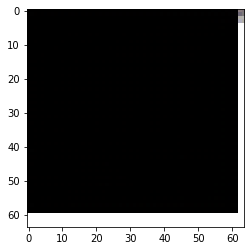

[1199/20000 : 1200] G Loss: 5.3188	 D Loss: 0.0006	 D Loss(real): 0.0000	 D Loss (fake):0.0006	


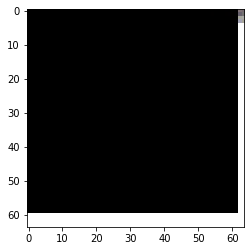

[1399/20000 : 1400] G Loss: 4.9978	 D Loss: 0.0054	 D Loss(real): 0.0000	 D Loss (fake):0.0054	


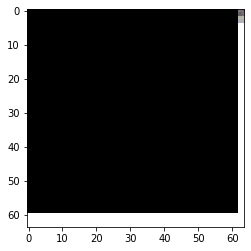

[1599/20000 : 1600] G Loss: 3.7811	 D Loss: 0.0113	 D Loss(real): 0.0000	 D Loss (fake):0.0113	


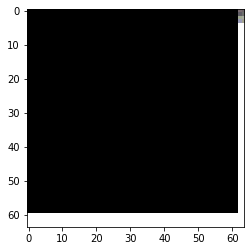

[1799/20000 : 1800] G Loss: 5.3167	 D Loss: 0.0027	 D Loss(real): 0.0000	 D Loss (fake):0.0027	


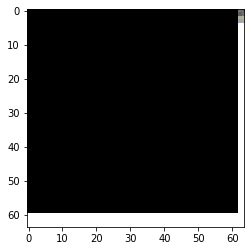

[1999/20000 : 2000] G Loss: 4.2469	 D Loss: 0.0126	 D Loss(real): 0.0000	 D Loss (fake):0.0126	


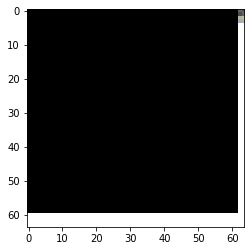

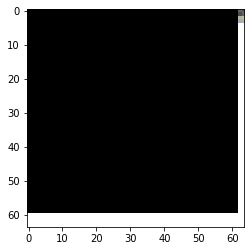

[2199/20000 : 2200] G Loss: 5.0815	 D Loss: 0.6044	 D Loss(real): 0.0000	 D Loss (fake):0.6044	


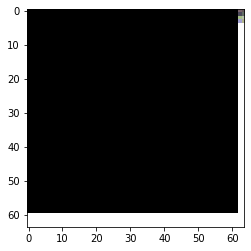

[2399/20000 : 2400] G Loss: 5.7786	 D Loss: 0.0062	 D Loss(real): 0.0000	 D Loss (fake):0.0062	


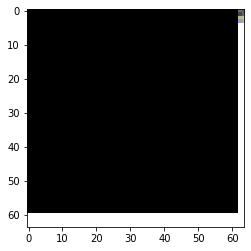

[2599/20000 : 2600] G Loss: 5.0421	 D Loss: 0.0040	 D Loss(real): 0.0000	 D Loss (fake):0.0040	


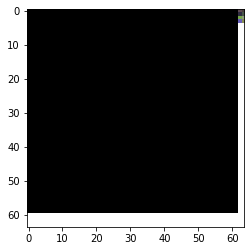

[2799/20000 : 2800] G Loss: 5.7134	 D Loss: 0.0030	 D Loss(real): 0.0000	 D Loss (fake):0.0030	


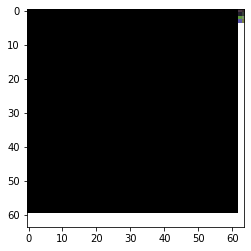

[2999/20000 : 3000] G Loss: 5.5734	 D Loss: 0.0041	 D Loss(real): 0.0000	 D Loss (fake):0.0041	


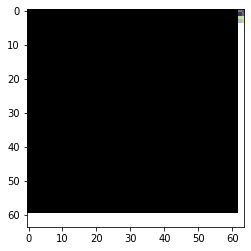

[3199/20000 : 3200] G Loss: 4.3362	 D Loss: 0.0069	 D Loss(real): 0.0000	 D Loss (fake):0.0069	


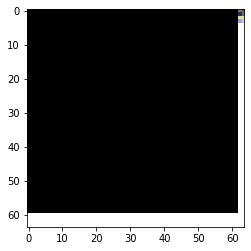

[3399/20000 : 3400] G Loss: 5.1716	 D Loss: 0.0075	 D Loss(real): 0.0000	 D Loss (fake):0.0075	


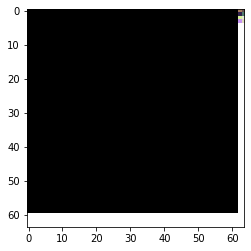

[3599/20000 : 3600] G Loss: 4.5953	 D Loss: 0.0126	 D Loss(real): 0.0000	 D Loss (fake):0.0126	


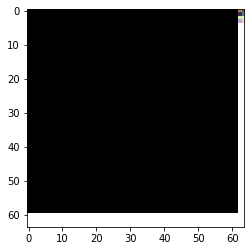

[3799/20000 : 3800] G Loss: 4.2426	 D Loss: 0.0081	 D Loss(real): 0.0000	 D Loss (fake):0.0081	


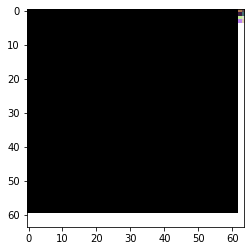

[3999/20000 : 4000] G Loss: 7.1261	 D Loss: 0.0009	 D Loss(real): 0.0000	 D Loss (fake):0.0009	


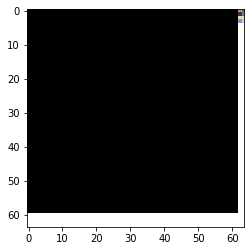

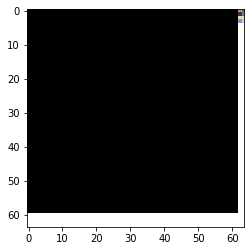

[4199/20000 : 4200] G Loss: 4.9154	 D Loss: 0.0084	 D Loss(real): 0.0000	 D Loss (fake):0.0084	


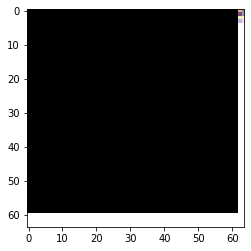

[4399/20000 : 4400] G Loss: 4.8235	 D Loss: 0.0067	 D Loss(real): 0.0000	 D Loss (fake):0.0067	


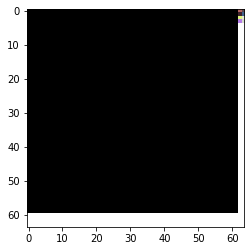

[4599/20000 : 4600] G Loss: 5.7844	 D Loss: 0.0029	 D Loss(real): 0.0000	 D Loss (fake):0.0029	


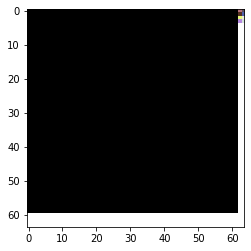

KeyboardInterrupt: ignored

In [0]:
overfit_train(zappos_overfit, g_net, d_net, g_optimizert_overfit, d_optimizert_overfit, 20000, overfit_img)
# gan_train(zappos_overfit, g_net, d_net, g_optimizert_overfit, d_optimizert_overfit, 25)

## Question 5. Least Square GAN (Extra Credit)
The main idea of LSGAN is to use loss function that provides smooth and non-saturating gradient in discriminator 
D


**Q5a (10):** Implement the above GAN model with the follwing objective:
$$\begin{aligned}
&\min _{D} V_{\mathrm{LSGAN}}(D)=\frac{1}{2} \mathbb{E}_{\boldsymbol{x} \sim p_{\mathrm{dnta}}(\boldsymbol{x})}\left[(D(\boldsymbol{x})-1)^{2}\right]+\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z})))^{2}\right]\\
&\min _{G} V_{\mathrm{LSGAN}}(G)=\frac{1}{2} \mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}\left[(D(G(\boldsymbol{z}))-1)^{2}\right]
\end{aligned}$$




**Q5b (5):**Plot the outputs for 10 intermediate stages of training and visulaize the generated outputs for those intermediate stages.

**Q5c (5):**Generate 10 samples using the trained model

## Submission Instructions

The deadline for all parts of this assignment is **March 5, 2020 at 11:59pm**.

There are two submissions on Gradescope:
*   HW3 - Computer Vision (Writeup)
*   HW3 - Computer Vision (Programming)

For *HW3 - Computer Vision (Writeup)* submit your written responses to the questions above as the file **"522_HW3_writeup.pdf"**

For *HW3 - Computer Vision (Programming)* submit the following files as your submission:
1.   522_HW3_submission.dill
2.   This notebook, named as 522_HW3_notebook.ipynb

**Leaderboard:** When you submit, you can choose to add yourself as part of the leaderboard! Extra credit may be awarded to those that perform particularly well on the leaderboard.

**Gradescope Score:** After you submit, you'll see that all of the classifier questions are out of zero points. To encourage as much hypertuning, we will not be releasing the accuracy cutoffs until after the late deadline has passed.

In [0]:
import dill
import os

file_to_obj_map = {
    'test_case_1b' : test_case_1b,
    'test_case_1c' : test_case_1c,
    'test_case_1d' : test_case_1d,
    'test_case_2a' : test_case_2a,
}

tests_path = "522_HW3_submission.dill"
with open(tests_path, 'wb') as pickle_file:
  dill.dump(file_to_obj_map, pickle_file)